In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

#Import required data
ratings=pd.read_csv("movieRatings.csv")
movies=pd.read_csv("movies.csv")

#Change the data such that each user would have a corresponding rating to each movie, and if they have not rated that specific movie, then their rating would be NaN
ratings_mod = ratings.pivot(index='movieId',columns='userId',values='rating')

#Change NaN ratings to be 0 to avoid data type errors
ratings_mod.fillna(0,inplace=True)
ratings_mod.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


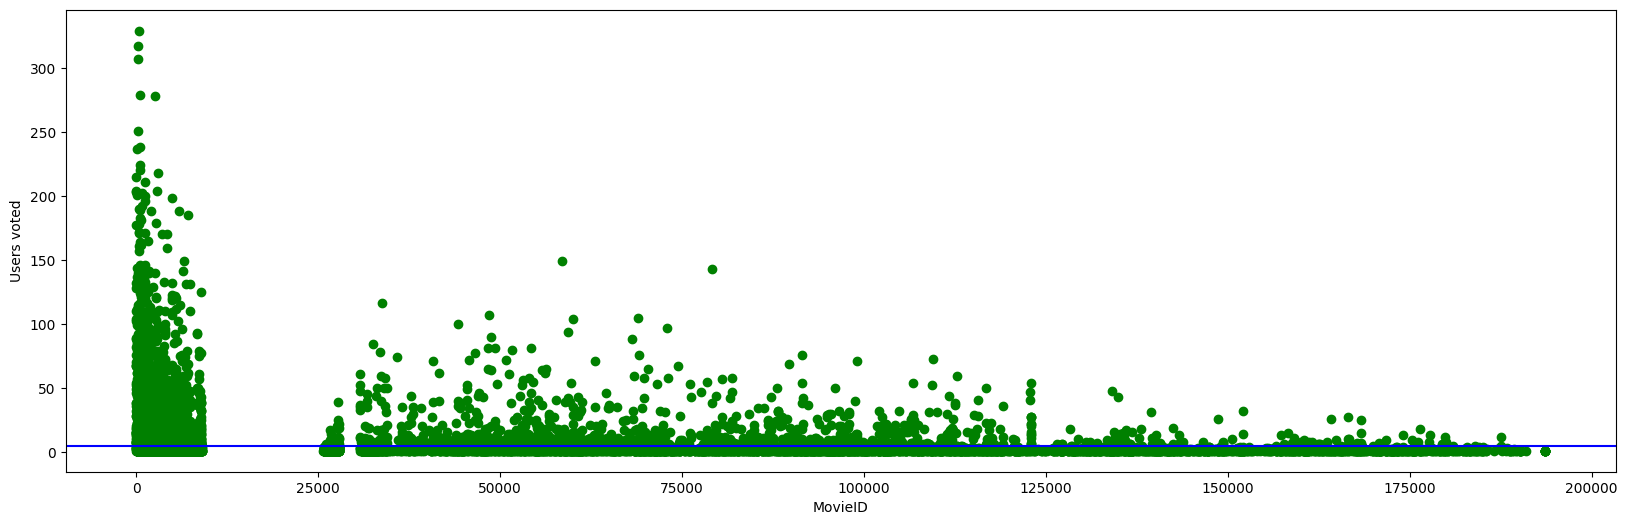

In [11]:
'''Since the data contains a lot of movies that aren't voted on by many users, we will remove those in order to remove inaccurate recommendations. We will set the threshold at 5, such that
any movie with 5 or less users give it a rating will be considered noise and removed from the dataset. We will do the same thing to users, since a user that only gave a few ratings
will not accurately represent a subset of movie watchers who frequently watch and rate movies, and thus might skew our data. Moreover, users with very few ratings can also happen to be bots
so we will also want to remove them for that purpose. We will set the threshold at 10, such that any user that rated 10 or less movies will be removed from the dataset. '''
user_vote_count = ratings.groupby('movieId')['rating'].agg('count')
movie_vote_count = ratings.groupby('userId')['rating'].agg('count')
     
#Plot the data points we will be eliminating in terms of movies
f,axis = plt.subplots(1,1,figsize=(20,6))
plt.scatter(user_vote_count.index,user_vote_count,color='g')
plt.axhline(y=5,color='b')
plt.xlabel('MovieID')
plt.ylabel('Users voted')
plt.show()

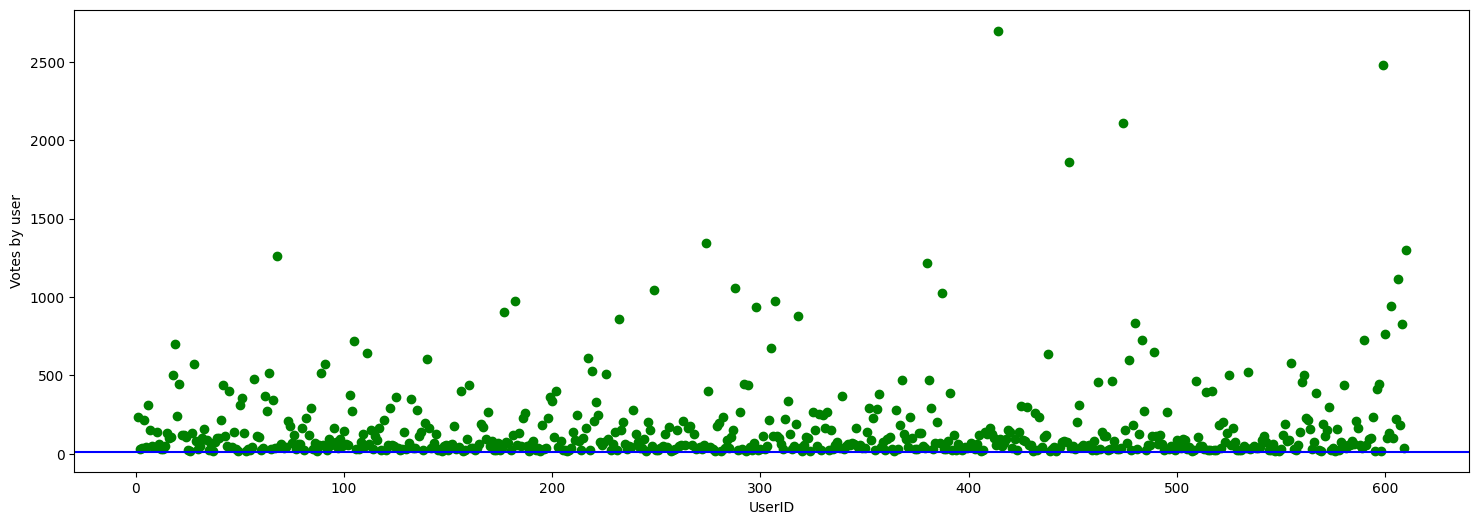

In [12]:
#Remove all movies that had 5 or less users rate it
ratings_mod = ratings_mod.loc[user_vote_count[user_vote_count > 5].index,:]
#Plot the data points we will be eliminating in terms of users
f,axis = plt.subplots(1,1,figsize=(18,6))
plt.scatter(movie_vote_count.index,movie_vote_count,color='g')
plt.axhline(y=10,color='b')
plt.xlabel('UserID')
plt.ylabel('Votes by user')
plt.show()

In [13]:
#Remove all users that had 10 or less ratings given to movies, and display the final dataset
ratings_mod=ratings_mod.loc[:,movie_vote_count[movie_vote_count > 10].index]
ratings_mod.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
'''Since we filled in the data with a lot of zeroes for NaN entries, we now have a very sparse matrix. To reduce wastage, we will use the csr_matrix function provided by scipy to remove
sparsity from our dataset. Then, reset the index of the original pd frame.'''
ratingsFixed = csr_matrix(ratings_mod.values)
ratings_mod.reset_index(inplace=True)
     
'''Define our Kth Nearest Neighbor model to compare based on cosine distance between neighbors. Since our dataset is small, we can use the brute force algorithm and not worry about the K-D
tree or ball tree algorithms. Set the n_neighbors parameter to 30 because we do want a decent influence in number of neighbors reached, but not too many as to overfit the data.'''
knnModel = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30)
knnModel.fit(ratingsFixed)
     
'''Create the function that recommend movies. Note that the movies that were previously removed due to having
5 or less ratings will not work in this function, as it will produce recommendations that will be inaccurate
due to not having many user ratings datapoints.'''
def recommend(movie_name, movies):
   
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idList= movie_list.iloc[0]['movieId']
        movie_idList = ratings_mod[ratings_mod['movieId'] == movie_idList].index[0]
        dist , ind = knnModel.kneighbors(ratingsFixed[movie_idList], n_neighbors = 6)    
        recommendedInd = sorted(list(zip(ind.squeeze().tolist(), dist.squeeze().tolist())), key=lambda j: j[1])[:0:-1]
        recommendList = []

        for val in recommendedInd:
            movie_idList = ratings_mod.iloc[val[0]]['movieId']
            ids = movies[movies['movieId'] == movie_idList].index
            recommendList.append({'Title':movies.iloc[ids]['title'].values[0]})
        df = pd.DataFrame(recommendList,index=range(1,6))
        return df

    else:
        return "The movie you entered is not within our databank, please try again!"

In [15]:
#For an entry that does not exist, we try with the Minecraft movie which is a movie newly released this year in 2025, so it should not be part of the 2018 database
recommend("Minecraft", movies)

'The movie you entered is not within our databank, please try again!'